In [50]:
#!pip3 install numpy pandas matplotlib sparqlwrapper

# Collecte de données

## Récupération des images

In [51]:
import requests
import glob
import shutil
import os
import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get cities
query = """SELECT DISTINCT ?tour ?tourLabel ?image {
  ?tour wdt:P31 wd:Q12518;
          wdt:P18 ?image.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 100"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["tourLabel"]["value"],
            result["image"]["value"],
        )
    )

dataframe = pd.DataFrame(array, columns=["tour", "image"])
dataframe = dataframe.astype(
    dtype={"tour": "<U200", "image": "<U200"}
)



def download_image(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(os.path.join("images", os.path.basename(url)), "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

#dataframe.image.apply(download_image)

## Métadonnées des images

In [52]:
import os
import json
from fractions import Fraction
from PIL import Image
from PIL.ExifTags import TAGS
import numpy as np
from sklearn.cluster import KMeans


# Create the users directory if it doesn't exist
if not os.path.exists('json'):
    os.makedirs('json')



def get_exif_data(img):
    exif_data = img.getexif()
    exif = {}
    if exif_data:
        for tag, value in exif_data.items():
            if tag in TAGS:
                if isinstance(value, bytes):
                    value = value.decode(errors='ignore')
                    
                elif isinstance(value, (Fraction, int, float)):
                    value = str(value)
                elif isinstance(value, tuple):
                    value = tuple(str(v) for v in value)
                else:
                    value = str(value)
                exif[TAGS[tag]] = value
    return exif

def get_image_metadata(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Ensure image is in RGB mode
    img_size = img.size
    exif_data = get_exif_data(img)
    exif_data.pop('MakerNote', None)
    img = img.resize((100, 100))  # Redimensionner pour accélérer le traitement
    img_array = np.array(img)
    img_array = img_array.reshape((img_array.shape[0] * img_array.shape[1], 3))
    
    kmeans = KMeans(n_clusters=5, n_init=10)
    kmeans.fit(img_array)
    
    # Obtenir les couleurs des clusters
    couleur_favorite = kmeans.cluster_centers_
    metadata = {
        "filename": os.path.basename(image_path),
        "format": img.format,
        "size": img_size,
        "mode": img.mode,
        "orientation": "landscape" if img_size[0] > img_size[1] else "portrait",
        "orientation_id": 0 if img.width > img.height else 1,
        "exif": exif_data,
        "couleur_favorite": [couleur_favorite[i].tolist() for i in np.argsort(couleur_favorite.sum(axis=1))],
    }
    return metadata

def save_metadata_to_json(metadata, output_file="json/image_tags.json"):
    try:
        with open(output_file, 'r') as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        data = []

    data.append(metadata)

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

def recup_metadata():
    # Effacer le contenu du fichier au début du programme
    open("json/image_tags.json", 'w').close()
    # Récupérer les fichiers images
    image_files = [f"images/{f}" for f in os.listdir('images') if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
    # Récupérer les métadonnées de chaque image
    for image_path in image_files:
        metadata = get_image_metadata(image_path)
        save_metadata_to_json(metadata)
        print(f"Métadonnées de l'image {image_path} enregistrées.")

#recup_metadata()

## Création des users

In [53]:
import json
import os
import random

# Create the users directory if it doesn't exist
if not os.path.exists('json'):
    os.makedirs('json')

# Get metadata for all images
with open('json/image_tags.json', 'r') as f:
    metadata = json.load(f)

# Get all image filenames
image_filenames = [img['filename'] for img in metadata]

# Create a copy of image_filenames to draw from
available_images = image_filenames.copy()

# Dictionary to hold user data
users_data = {}

# For each user (1 to 5)
for i in range(5):
    # Randomly select 5 unique images for this user
    user_images = random.sample(available_images, 5)
    
    # Remove selected images from available pool
    for img in user_images:
        available_images.remove(img)
    
    # Add user data to dictionary
    users_data[f'user{i+1}'] = {
        'images': user_images,
        # You can add more user-specific information here
        'additional_info': {}
    }

# Save to a single JSON file
with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users_data, f, ensure_ascii=False, indent=2)

print("User file created with 5 unique images each")


User file created with 5 unique images each


# Tags favoris des users

### Couleur préférée

In [54]:
import json
import numpy as np
from sklearn.cluster import KMeans

# Charger les données des utilisateurs
with open('json/users.json', 'r') as f:
    users_data = json.load(f)

# Charger les métadonnées des images
with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)

for i in range(1, 6):
    # Récupérer les images de l'utilisateur
    user_images = users_data[f'user{i}']['images']

    # Récupérer les couleurs dominantes pour chaque image préférée de l'utilisateur
    couleur_favorite = []
    for image_filename in user_images:
        for img_data in image_metadata:
            if img_data['filename'] == image_filename:
                couleur_favorite.extend(img_data['couleur_favorite'])
                break

    # Convertir les couleurs dominantes en tableau numpy
    couleur_favorite = np.array(couleur_favorite)

    # Utiliser KMeans pour trouver la couleur la plus présente parmi les couleurs dominantes
    kmeans = KMeans(n_clusters=1, n_init=10)
    kmeans.fit(couleur_favorite)
    most_present_color = kmeans.cluster_centers_[0]

    # Ajouter la couleur dominante aux informations supplémentaires de l'utilisateur
    users_data[f'user{i}']['additional_info']['couleur_favorite'] = most_present_color.tolist()

# Sauvegarder les données mises à jour dans le fichier users.json
with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users_data, f, ensure_ascii=False, indent=2)

print("Couleurs dominantes ajoutées aux informations des utilisateurs.")


Couleurs dominantes ajoutées aux informations des utilisateurs.


### Orientation préférée

In [55]:
import os
import json

# Get metadata for all images
with open('json/image_tags.json', 'r') as f:
    metadata = json.load(f)

# Get users info
with open('json/users.json', 'r') as f:
    users = json.load(f)

for i in range(1, 6):
    sum_orientation = 0
    images = users[f'user{i}']['images']
    for image_data in metadata:
        if image_data['filename'] in images:
            sum_orientation += image_data['orientation_id']
    if sum_orientation > 3:
        users[f'user{i}']['additional_info']['orientation_favorite'] = 'portrait'
    else:
        users[f'user{i}']['additional_info']['orientation_favorite'] = 'paysage'

    

with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users, f, ensure_ascii=False, indent=2)

print("Les orientations préférées ont été ajoutées aux informations des utilisateurs.")


Les orientations préférées ont été ajoutées aux informations des utilisateurs.


### Taille favorite

In [56]:
import json
import numpy as np

# Charger les métadonnées des images
with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)

# Calculer la taille moyenne des images pour déterminer les catégories de taille
sizes = [w * h for img in image_metadata for w, h in [img['size']]]
avg_size = np.mean(sizes)

# Charger les données des utilisateurs
with open('json/users.json', 'r') as f:
    users = json.load(f)

# Déterminer les catégories de taille en fonction de la taille moyenne
for i in range(1, 6):
    # Ajouter les informations sur la taille des images
    user_images = users[f'user{i}']['images']
    user_sizes = [img_data['size'] for img_data in image_metadata if img_data['filename'] in user_images]
    
    # Déterminer la taille favorite
    user_avg_size = np.mean([w * h for w, h in user_sizes])
    if user_avg_size < avg_size * 0.5:
        size_category = 'vignette'
    elif user_avg_size < avg_size:
        size_category = 'moyenne'
    elif user_avg_size < avg_size * 1.5:
        size_category = 'grande'
    else:
        size_category = 'très grande'
    
    users[f'user{i}']['additional_info']['taille_favorite'] = size_category

# Sauvegarder les données mises à jour dans le fichier users.json
with open('json/users.json', 'w', encoding='utf-8') as f:
    json.dump(users, f, ensure_ascii=False, indent=2)

print("Les tailles préférées ont été ajoutées aux informations des utilisateurs.")

Les tailles préférées ont été ajoutées aux informations des utilisateurs.


# Visualisation des données

/tmp/ipykernel_9453/4021894447.py:63: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/media/leo/OS/Users/Leo/Documents/cpe/4ETI/CLBD/DATAMINING/DM_projetlinux/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


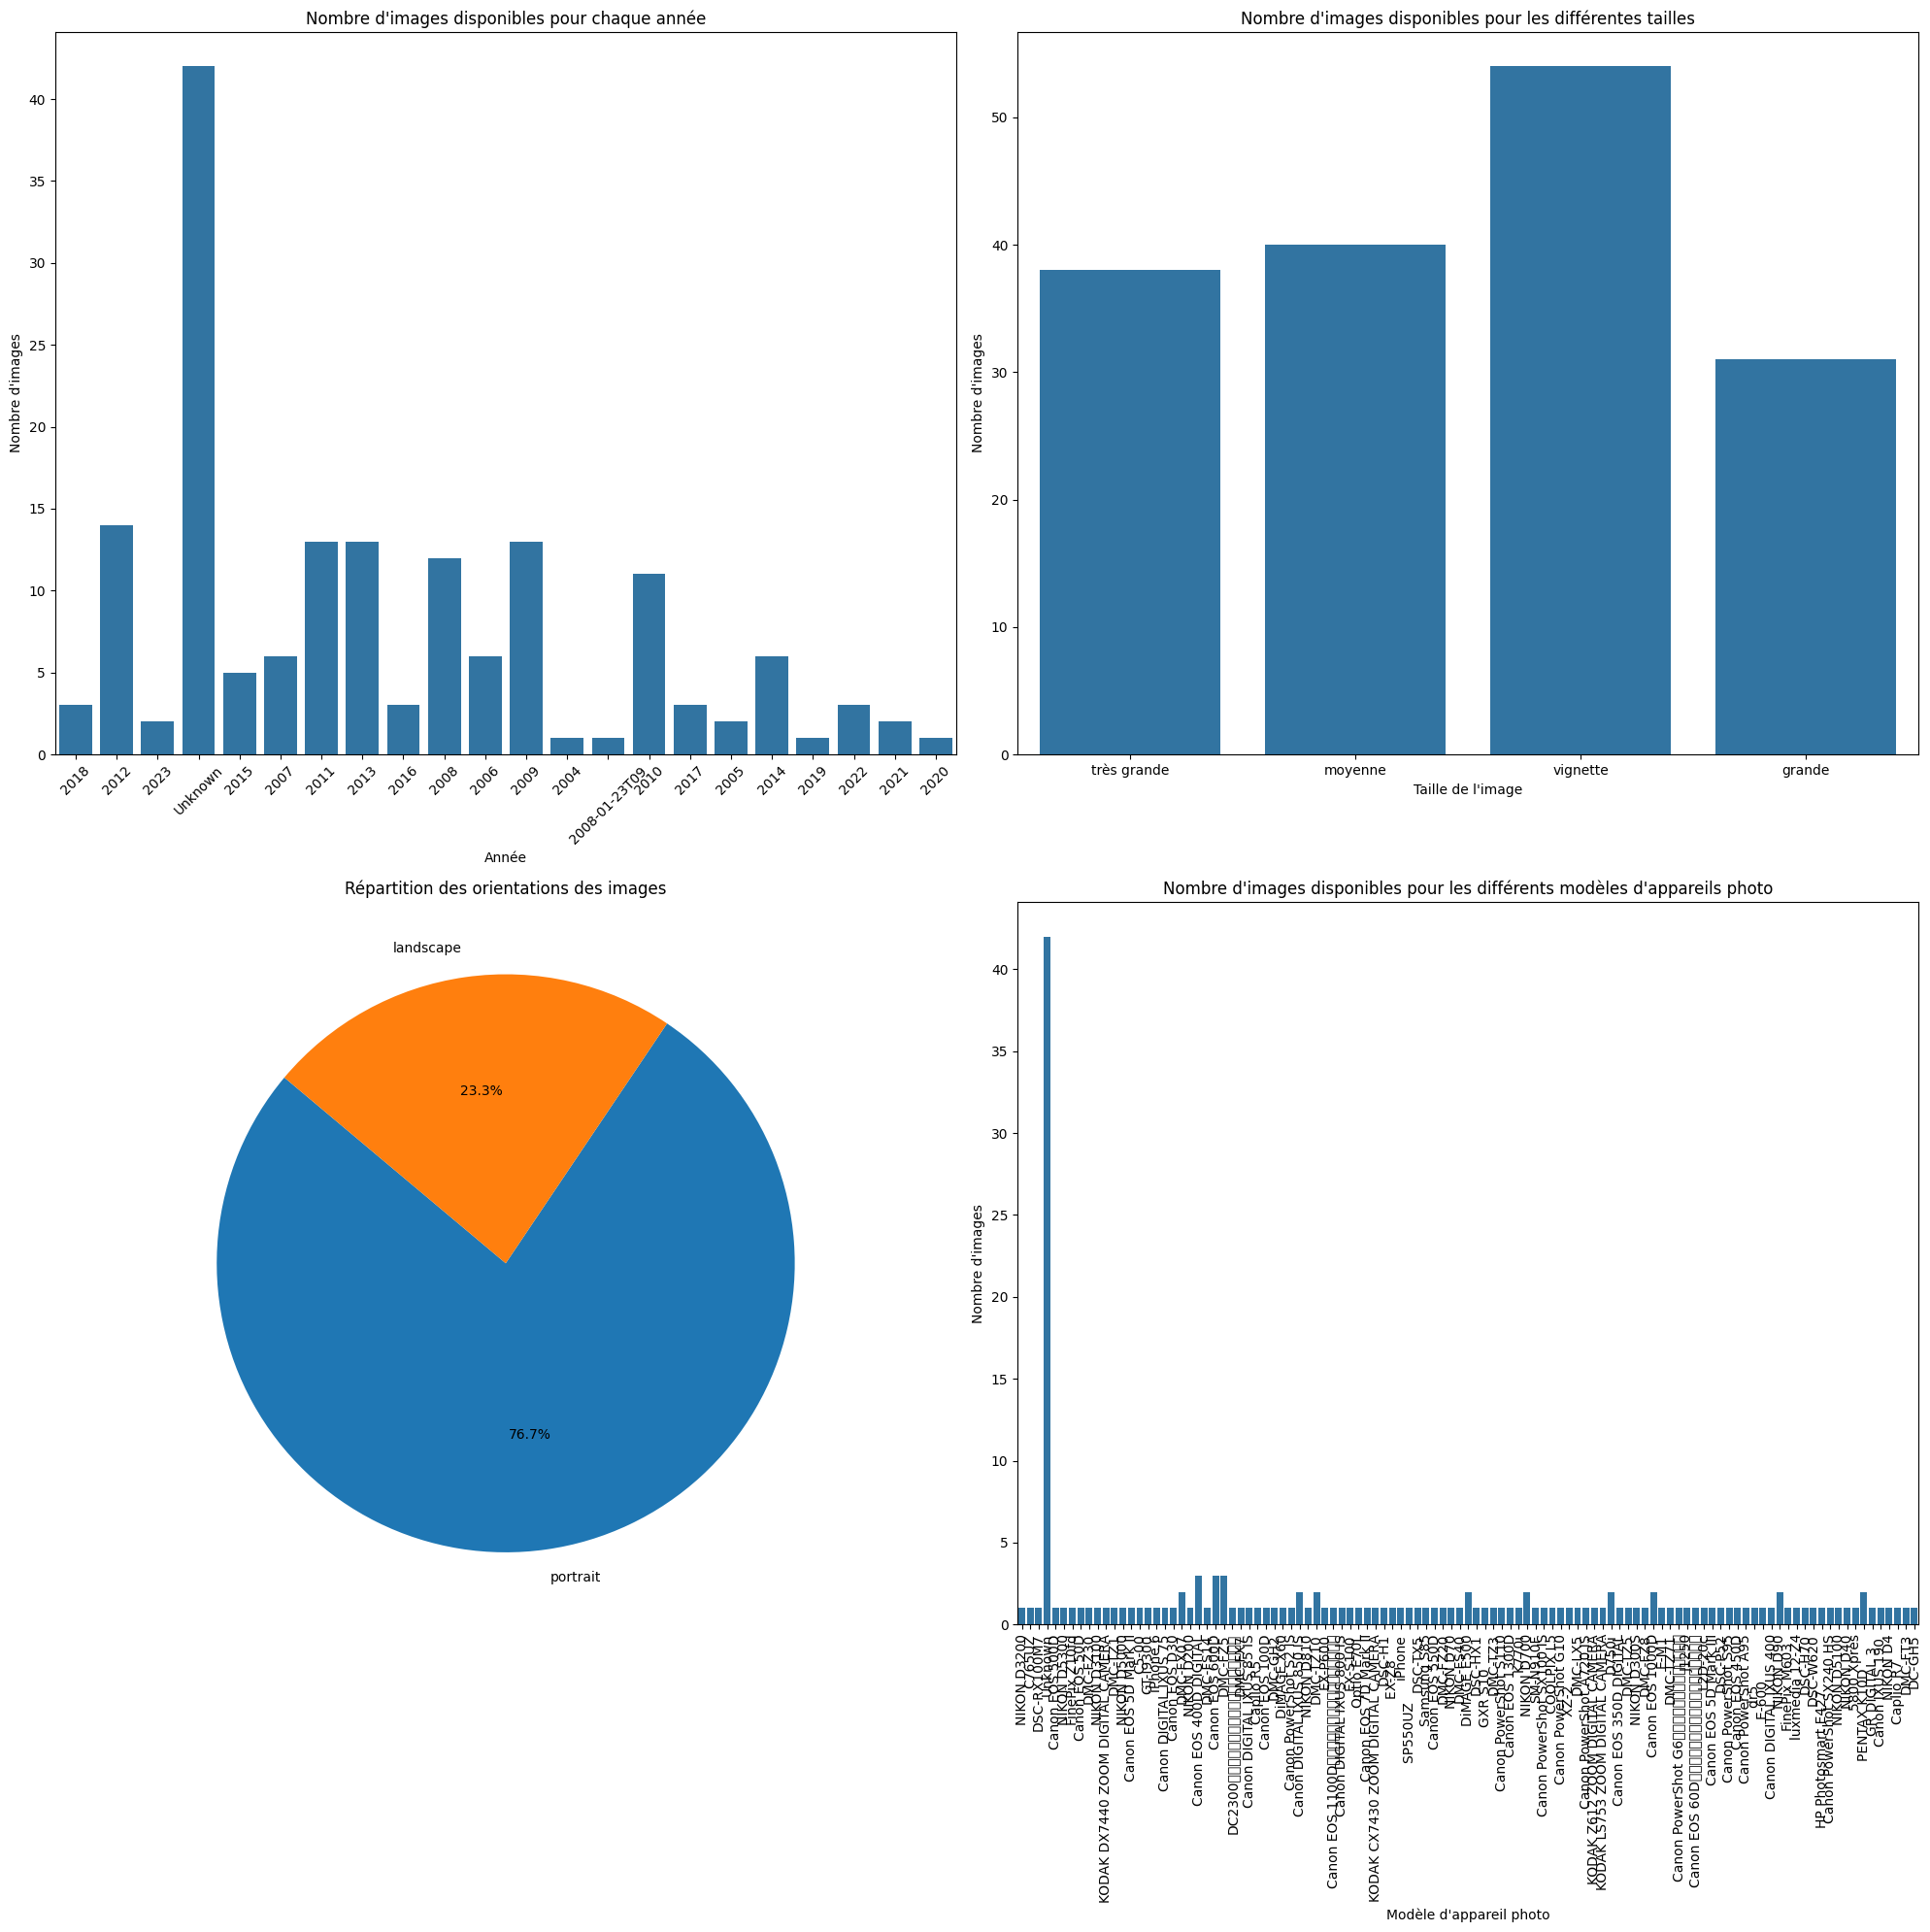

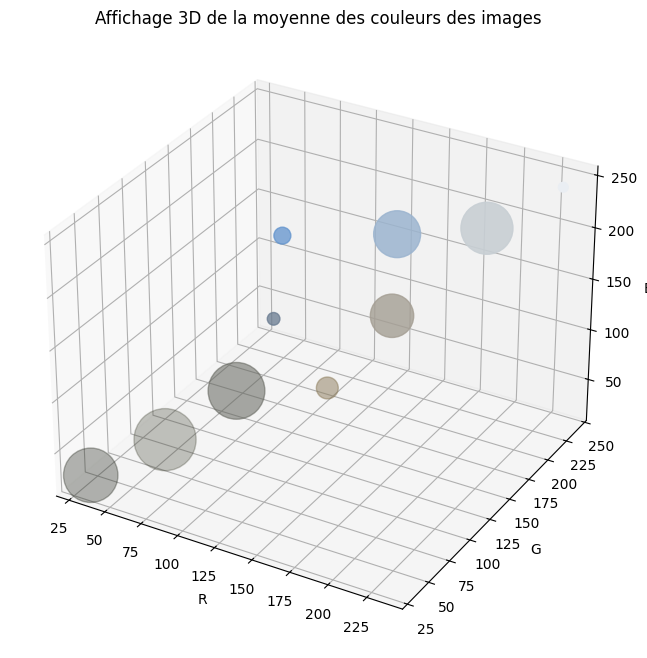

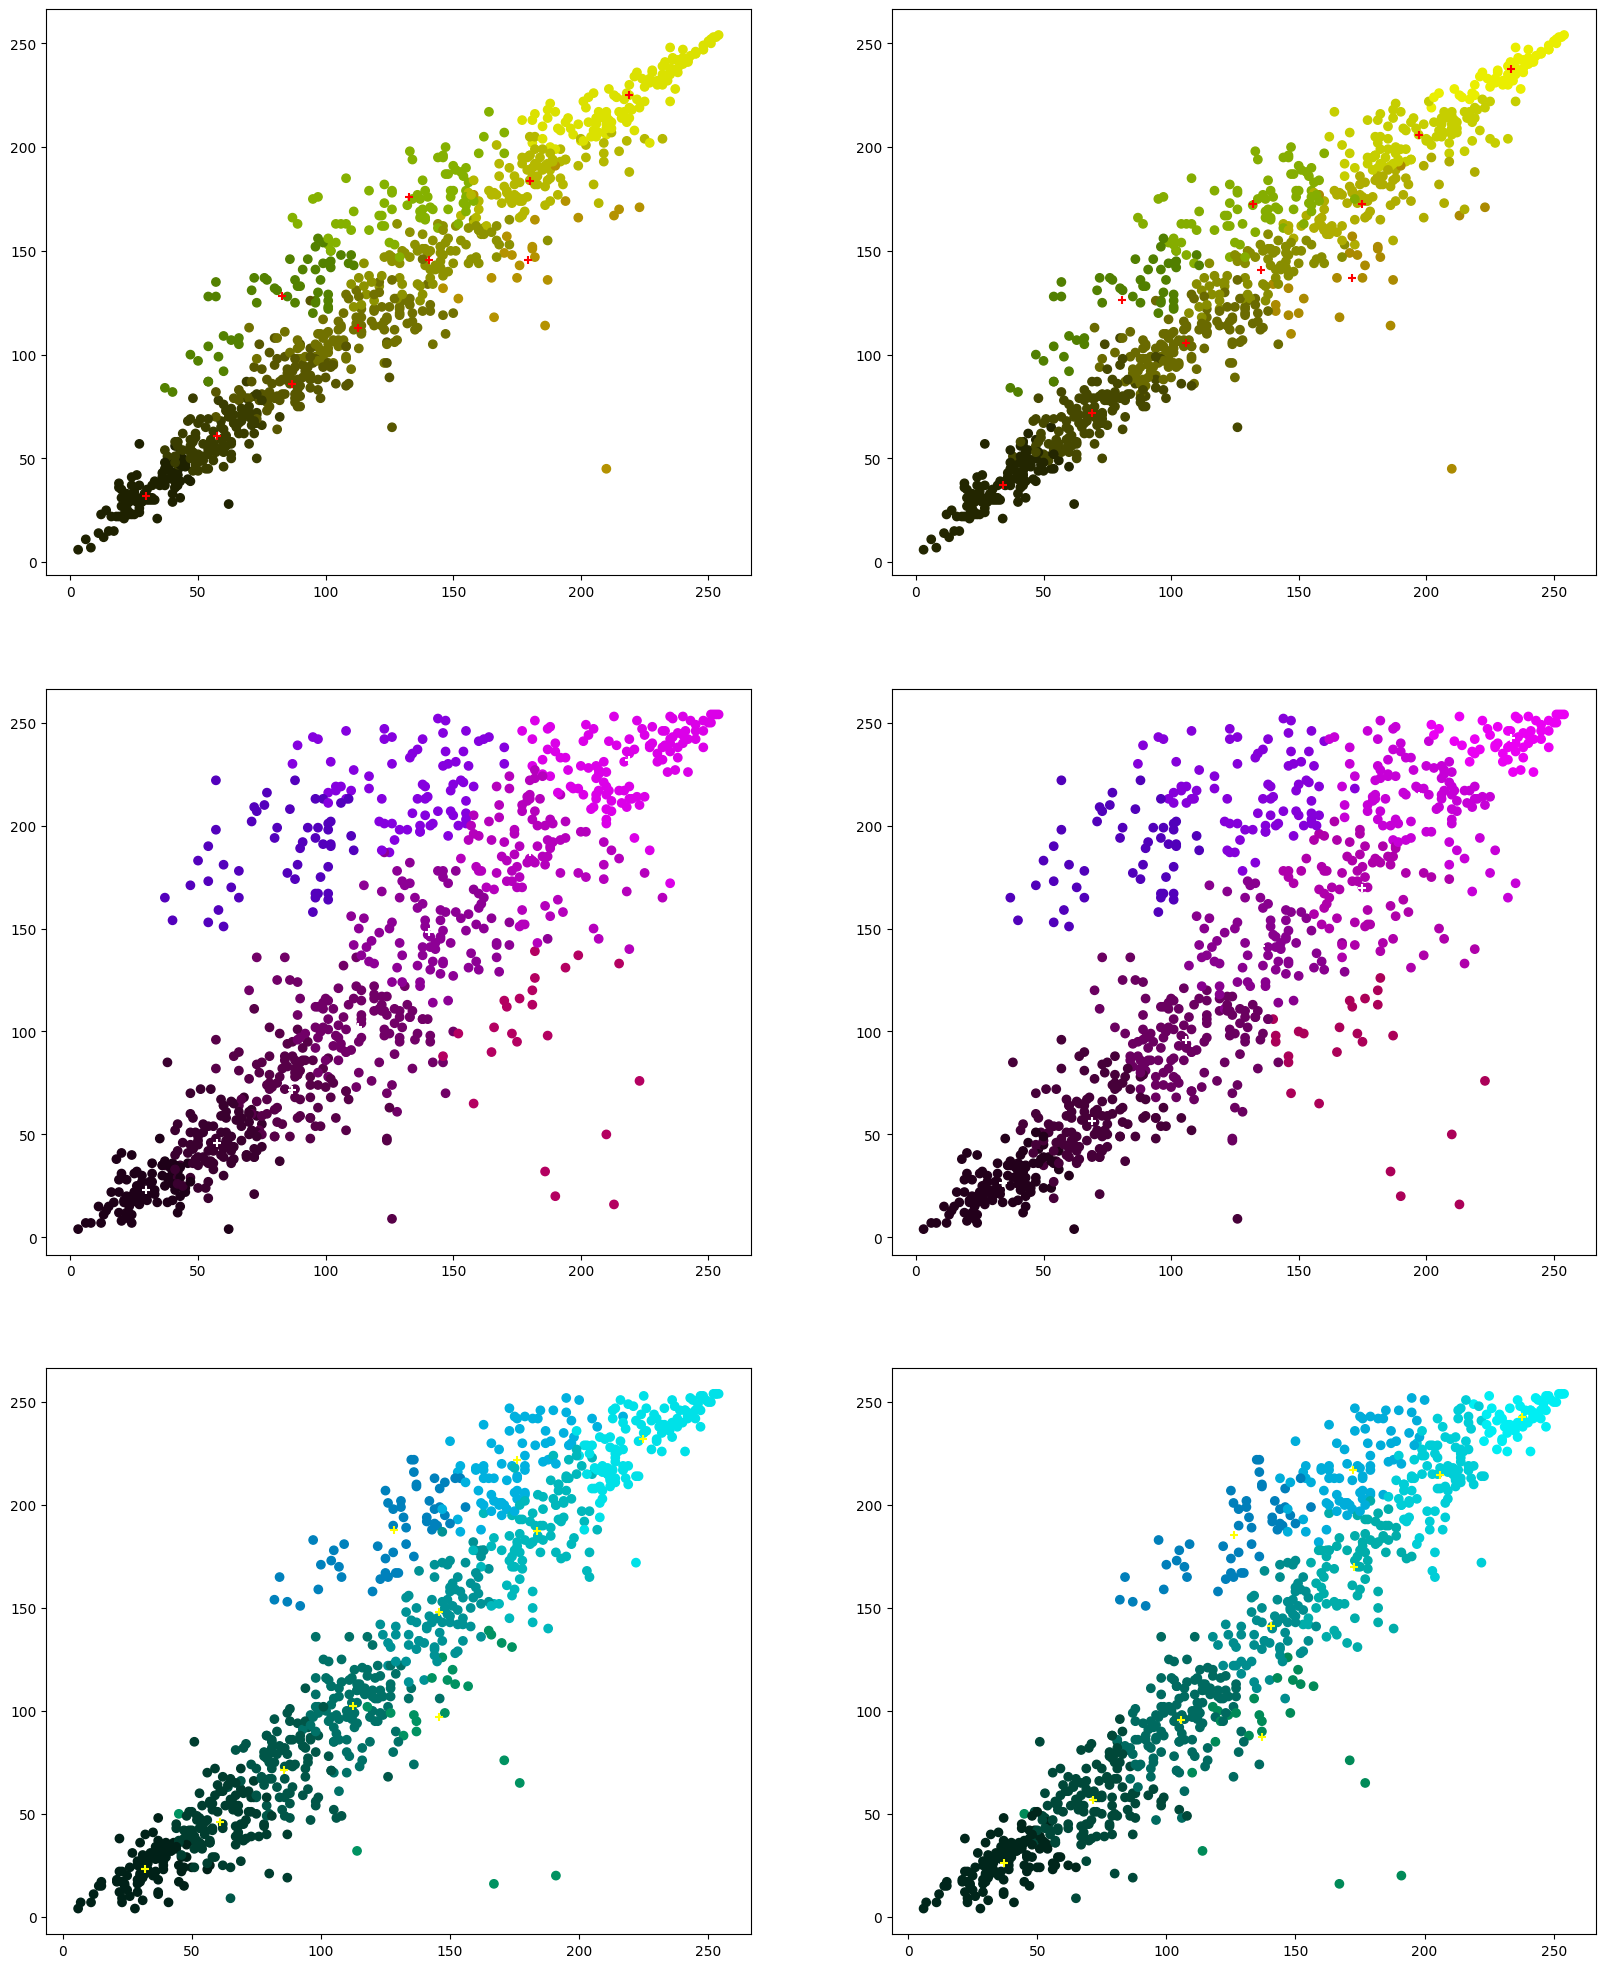

In [ ]:

#%pip install seaborn

import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, minmax_scale



with open('json/image_tags.json', 'r') as f:
    image_metadata = json.load(f)

# Nombre d'images disponibles pour chaque année
years = [img['exif'].get('DateTime', 'Unknown').split(':')[0] for img in image_metadata]
year_counts = Counter(years)

# Nombre d'images disponibles pour les différentes tailles
sizes = [img['size'] for img in image_metadata]
size_categories = ['vignette' if w * h < avg_size * 0.5 else 'moyenne' if w * h < avg_size else 'grande' if w * h < avg_size * 1.5 else 'très grande' for w, h in sizes]
size_counts = Counter(size_categories)

# Nombre d'images disponibles pour les différentes orientations
orientations = [img['orientation'] for img in image_metadata]
orientation_counts = Counter(orientations)

# Nombre d'images disponibles pour les différents modèles d'appareils photo
camera_models = [img['exif'].get('Model', 'Unknown') for img in image_metadata]
camera_model_counts = Counter(camera_models)


def affichage_grille():

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

    # Nombre d'images disponibles pour chaque année
    sns.barplot(ax=axes[0, 0], x=list(year_counts.keys()), y=list(year_counts.values()))
    axes[0, 0].set_title('Nombre d\'images disponibles pour chaque année')
    axes[0, 0].set_xlabel('Année')
    axes[0, 0].set_ylabel('Nombre d\'images')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Nombre d'images disponibles pour les différentes tailles
    sns.barplot(ax=axes[0, 1], x=list(size_counts.keys()), y=list(size_counts.values()))
    axes[0, 1].set_title('Nombre d\'images disponibles pour les différentes tailles')
    axes[0, 1].set_xlabel('Taille de l\'image')
    axes[0, 1].set_ylabel('Nombre d\'images')

    # Nombre d'images disponibles pour les différentes orientations
    axes[1, 0].pie(orientation_counts.values(), labels=orientation_counts.keys(), autopct='%1.1f%%', startangle=140)
    axes[1, 0].set_title('Répartition des orientations des images')

    # Nombre d'images disponibles pour les différents modèles d'appareils photo
    sns.barplot(ax=axes[1, 1], x=list(camera_model_counts.keys()), y=list(camera_model_counts.values()))
    axes[1, 1].set_title('Nombre d\'images disponibles pour les différents modèles d\'appareils photo')
    axes[1, 1].set_xlabel('Modèle d\'appareil photo')
    axes[1, 1].set_ylabel('Nombre d\'images')
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

affichage_grille()
def infos_couleurs(image_metadata, cluster_count=10):
    import matplotlib.pyplot as plt

    # Collect all colors from image metadata
    all_colors = [color for img in image_metadata for color in img['couleur_favorite']]
    all_colors = np.array(all_colors, dtype=np.uint8)

    # MiniBatchKMeans clustering
    mclusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    mclusters.fit(all_colors)

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))

    # Scatter plot for RG (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(mclusters.cluster_centers_[j][0]), math.ceil(mclusters.cluster_centers_[j][1]), 0) for j in mclusters.labels_]
    axes[0, 0].scatter(all_colors[:, 0], all_colors[:, 1], c=colors)
    axes[0, 0].scatter(mclusters.cluster_centers_[:, 0], mclusters.cluster_centers_[:, 1], marker="+", c="red")

    # Scatter plot for RB (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(mclusters.cluster_centers_[j][0]), 0, math.ceil(mclusters.cluster_centers_[j][2])) for j in mclusters.labels_]
    axes[1, 0].scatter(all_colors[:, 0], all_colors[:, 2], c=colors)
    axes[1, 0].scatter(mclusters.cluster_centers_[:, 0], mclusters.cluster_centers_[:, 2], marker="+", c="white")

    # Scatter plot for GB (RGB)
    colors = ["#%02x%02x%02x" % (0, math.ceil(mclusters.cluster_centers_[j][1]), math.ceil(mclusters.cluster_centers_[j][2])) for j in mclusters.labels_]
    axes[2, 0].scatter(all_colors[:, 1], all_colors[:, 2], c=colors)
    axes[2, 0].scatter(mclusters.cluster_centers_[:, 1], mclusters.cluster_centers_[:, 2], marker="+", c="yellow")

    # KMeans clustering
    clusters = KMeans(n_clusters=cluster_count, n_init=2)
    clusters.fit(all_colors)

    # Scatter plot for RG (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(clusters.cluster_centers_[j][0]), math.ceil(clusters.cluster_centers_[j][1]), 0) for j in clusters.labels_]
    axes[0, 1].scatter(all_colors[:, 0], all_colors[:, 1], c=colors)
    axes[0, 1].scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 1], marker="+", c="red")

    # Scatter plot for RB (RGB)
    colors = ["#%02x%02x%02x" % (math.ceil(clusters.cluster_centers_[j][0]), 0, math.ceil(clusters.cluster_centers_[j][2])) for j in clusters.labels_]
    axes[1, 1].scatter(all_colors[:, 0], all_colors[:, 2], c=colors)
    axes[1, 1].scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 2], marker="+", c="white")

    # Scatter plot for GB (RGB)
    colors = ["#%02x%02x%02x" % (0, math.ceil(clusters.cluster_centers_[j][1]), math.ceil(clusters.cluster_centers_[j][2])) for j in clusters.labels_]
    axes[2, 1].scatter(all_colors[:, 1], all_colors[:, 2], c=colors)
    axes[2, 1].scatter(clusters.cluster_centers_[:, 1], clusters.cluster_centers_[:, 2], marker="+", c="yellow")

    plt.show()

# Affichage 3D de la moyenne des images
def affichage_3d(image_metadata, cluster_count=10):
    all_colors = [color for img in image_metadata for color in img['couleur_favorite']]
    all_colors = np.array(all_colors, dtype=np.uint8)

    clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    clusters.fit(all_colors)

    unique, frequency = np.unique(clusters.labels_, return_counts=True)
    scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

    colors = [
        "#%02x%02x%02x" % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2])
        ) for i in range(len(clusters.cluster_centers_))
    ]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        clusters.cluster_centers_[:, 0],
        clusters.cluster_centers_[:, 1],
        clusters.cluster_centers_[:, 2],
        c=colors,
        s=scaled_frequency
    )
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    plt.title('Affichage 3D de la moyenne des couleurs des images')
    plt.show()

affichage_3d(image_metadata)
infos_couleurs(image_metadata)
